# Notebook to view the parameters of the generated populations

Load the parameters for the three populations with different spin magnitude and tilt distributions but the same $\chi_\mathrm{eff}$ distribution. Compare them to the underlying distributions to see which systems passed the SNR threshold.

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import h5py 

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=False)
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)
import matplotlib.lines as mlines

import seaborn as sns
import pandas as pd

import sys
from scipy.stats import gaussian_kde

sys.path.append('./../../Code/PopulationInference')
from posterior_helper_functions import calculate_Gaussian_1D

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Load in data

In [2]:
pop1_underlying = pd.read_json('underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2_underlying = pd.read_json('underlying_population2_mediumSpin_fullmassrange.json')
pop3_underlying = pd.read_json('underlying_population3_lowSpinAligned_fullmassrange.json')

pop1_detected = pd.read_json('population1_highSpinPrecessing_fullmassrange.json')
pop2_detected = pd.read_json('population2_mediumSpin_fullmassrange.json')
pop3_detected = pd.read_json('population3_lowSpinAligned_fullmassrange.json')

In [3]:
pop1_underlying

,m1,m2,s1z,s2z,s1x,s2x,s1y,s2y,z,Dl,ra,dec,inc,phase,pol
0,8.958706,6.928670,0.228373,0.279672,0.520351,0.417535,-0.796443,0.618028,1.957844,15523.395301,3.478641,3.523800,1.580119,5.747945,1.071375
1,11.317846,8.624281,0.069669,-0.119976,0.354621,0.237997,-0.147959,0.025812,1.306770,9446.060140,0.597548,2.752137,1.410657,0.193907,0.101317
2,7.371796,7.082594,0.056352,0.278332,0.453458,0.423331,-0.125064,0.385207,1.918118,15139.232062,1.927504,2.953430,0.993299,4.596037,0.740523
3,11.282831,10.475086,-0.021050,0.055532,-0.255287,-0.311750,0.271420,0.596585,0.655887,4048.431336,4.953684,3.420858,1.735271,5.822926,4.738603
4,8.293589,6.525663,-0.176931,0.017512,0.286668,0.312587,-0.461926,0.409411,1.694449,13005.584005,0.445146,4.333884,1.312129,6.039024,3.961966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.486070,8.650309,0.192339,0.038382,-0.400687,0.643475,0.244145,-0.385889,0.407791,2289.633873,6.178922,2.171968,2.619479,0.582236,1.064187
9996,10.871261,10.411030,-0.026903,0.029519,-0.144938,0.015277,-0.195071,-0.123703,1.919147,15149.167681,0.783354,3.835989,0.567906,0.931832,4.319675
9997,34.693370,27.265576,-0.098295,0.401392,-0.093131,0.598116,-0.196838,-0.002347,0.598373,3621.747524,5.001962,2.379193,2.066744,3.283512,5.892591
9998,6.242852,6.128223,0.154912,0.110212,0.148948,-0.478296,-0.001222,-0.681712,1.053484,7240.946610,1.090369,4.270848,1.422344,5.285736,3.398482


In [4]:
# For plotting 
inj_kwargs = dict(ls=':', histtype='step', density=True, lw=1.5, label='underlying')
det_kwargs = dict(histtype='step', density=True, lw=1.5, label='passes snr cutoff')

## Look at spin distributions 

The effective spin $\chi_\mathrm{eff}$ distribution should be the same for each population, while the component spin magnitudes $\chi$ and tilt angles $\cos\theta$ distributions - and thus that for $\chi_\mathrm{p}$ - should be different. The distribution of in-plane angles $\phi_{12}$ should also be the same (uniform) for all three populations.

In [5]:
# Calculate chi_p
def calculate_ChiP(chi1, chi2, sint1, sint2, q): 
    term1 = chi1*sint1
    term2 = (2 + 4*q)/(4 + 3*q)*q*chi2*sint2
    chip = np.maximum(term1,term2)
    return chip 

In [6]:
# Calculate phi_12 
def calculate_phi12(s1x,s1y,s2x,s2y): 
    phi1 = np.arctan(s1y/s1x)
    phi2 = np.arctan(s2y/s2x)
    phi12 = phi2-phi1
    return phi12

In [7]:
# For selection effects (Will Farr 2020) 
will_selected = h5py.File('will-farr-selection-effects-comparison.h5', 'r')
will_chieff = np.asarray(will_selected['chi_effs'])
kde_will_chieff = gaussian_kde(will_chieff)

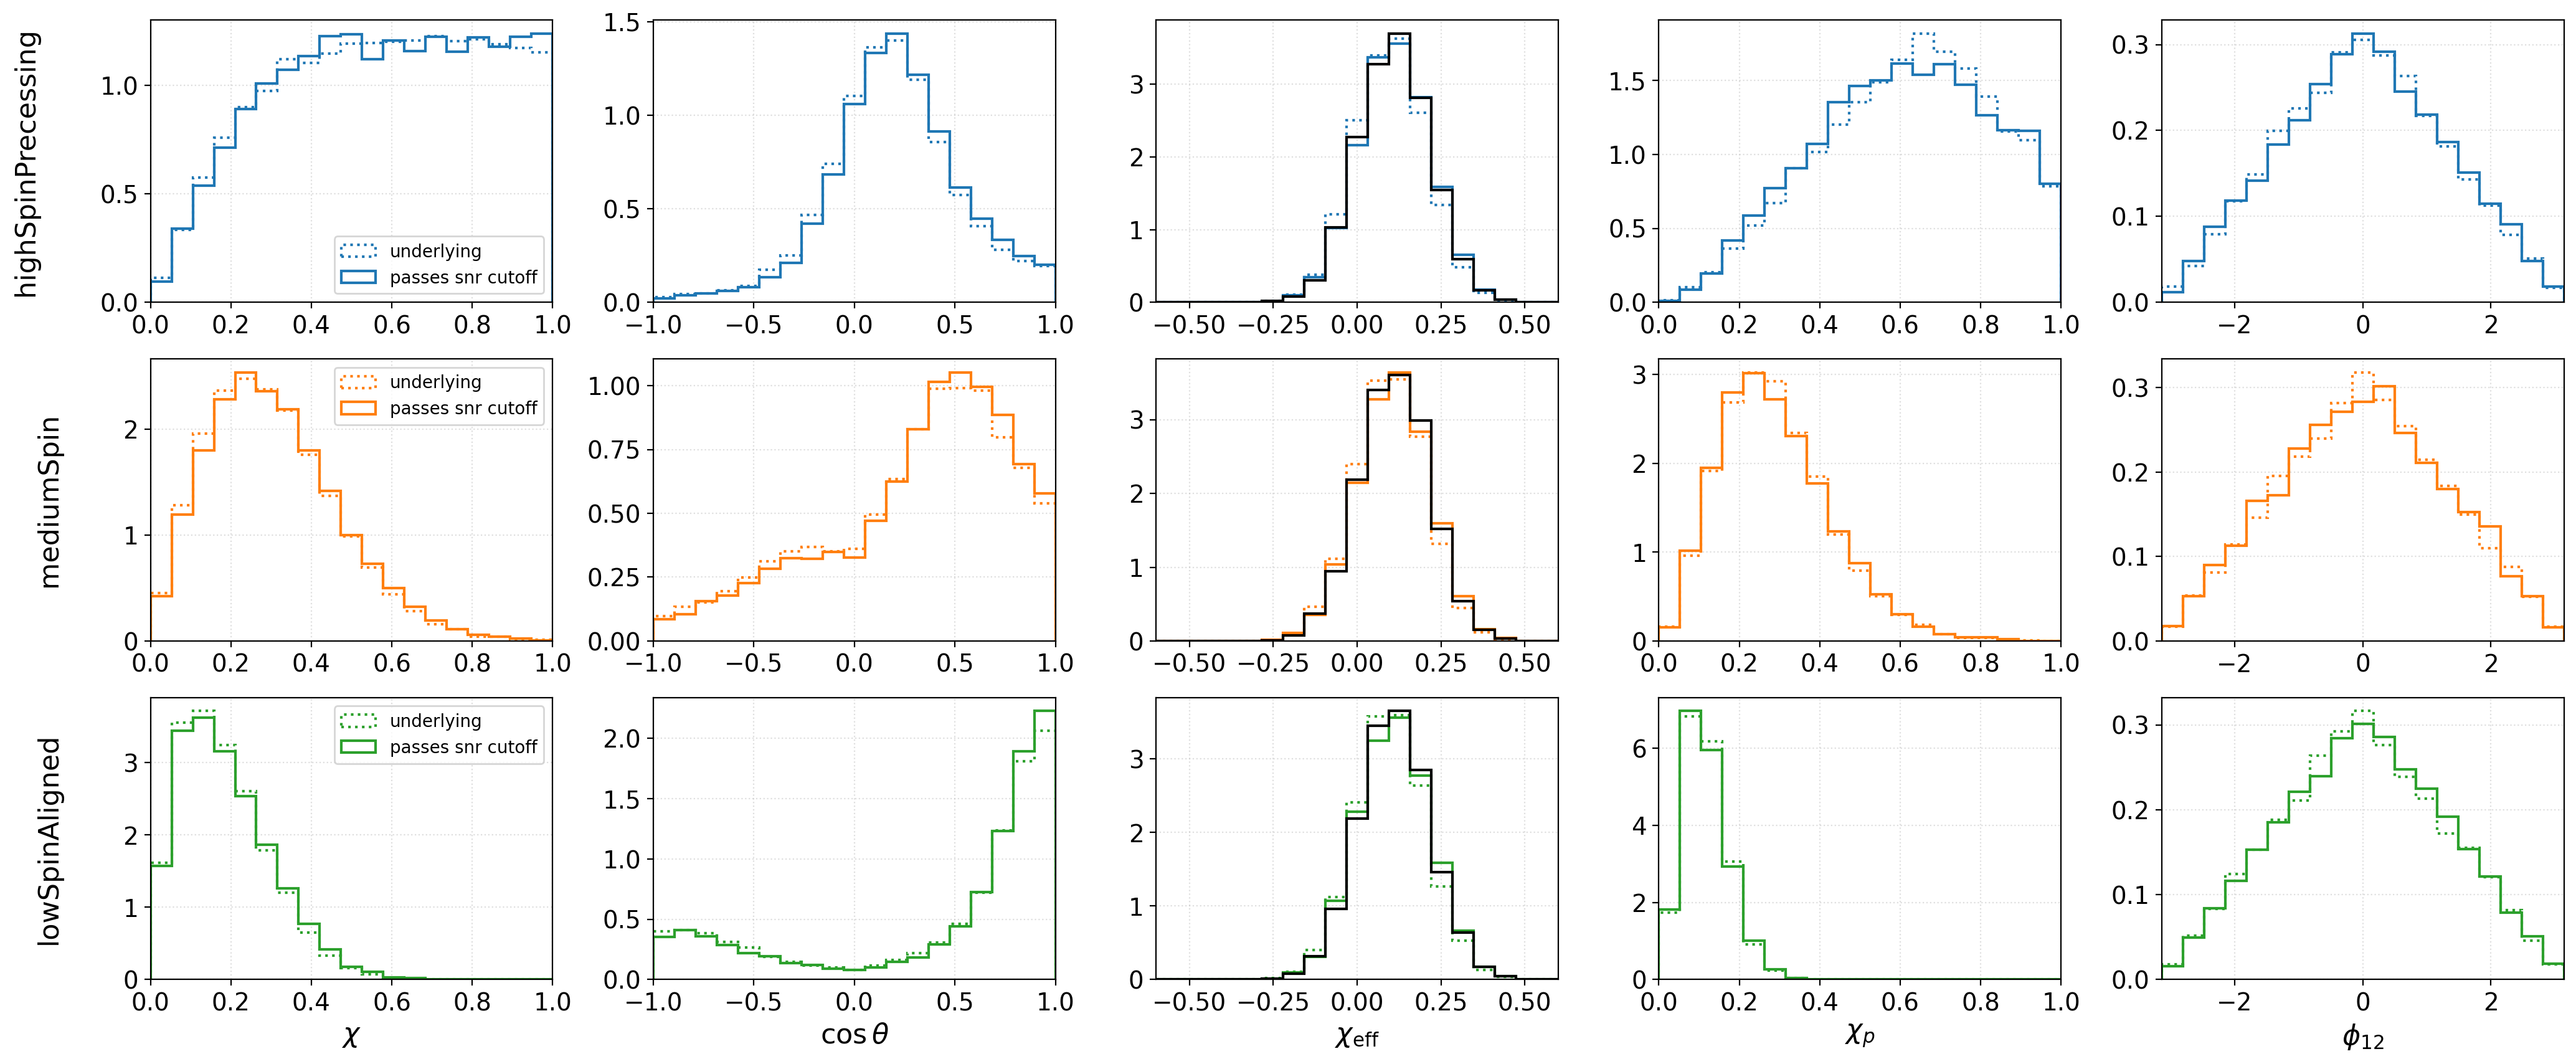

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25,10))

for i,pop_underlying in enumerate([pop1_underlying, pop2_underlying, pop3_underlying]):
    
    # spin magnitude
    chi1 = np.sqrt(pop_underlying.s1x**2 + pop_underlying.s1y**2 + pop_underlying.s1z**2)
    chi2 = np.sqrt(pop_underlying.s2x**2 + pop_underlying.s2y**2 + pop_underlying.s2z**2)
    chi = np.concatenate((chi1,chi2))
    axes[i][0].hist(chi, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 1, 20))
    axes[i][0].set_xlim(0,1)
    
    # tilt angle
    cost1 = pop_underlying.s1z/chi1
    cost2 = pop_underlying.s2z/chi2
    cost = np.concatenate((cost1,cost2))
    axes[i][1].hist(cost, **inj_kwargs, color=f'C{i}',bins=np.linspace(-1, 1, 20))
    axes[i][1].set_xlim(-1,1)
    
    # chi effective
    chieff = (pop_underlying.m1*pop_underlying.s1z + pop_underlying.m2*pop_underlying.s2z)/(pop_underlying.m1 + pop_underlying.m2)
    axes[i][2].hist(chieff, **inj_kwargs, color=f'C{i}', bins=np.linspace(-0.6, 0.6, 20))
    axes[i][2].set_xlim(-0.6,0.6)
    
    # chieff reweighting 
    chieff_weights = kde_will_chieff(chieff)
    chieff_weights_normed = chieff_weights/np.sum(chieff_weights)
    axes[i][2].hist(chieff, density=True, histtype='step', color='k', bins=np.linspace(-0.6, 0.6, 20), weights=chieff_weights_normed, zorder=3, lw=1.5)
    
    # chi p
    chip = calculate_ChiP(chi1, chi2, np.sin(np.arccos(cost1)), np.sin(np.arccos(cost2)), pop_underlying.m2/pop_underlying.m1)
    axes[i][3].hist(chip, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 1, 20))
    axes[i][3].set_xlim(0, 1)
    
    # phi 12
    phi12 = calculate_phi12(pop_underlying.s1x,pop_underlying.s1y,pop_underlying.s2x,pop_underlying.s2y)
    axes[i][4].hist(phi12, **inj_kwargs, color=f'C{i}', bins=np.linspace(-np.pi, np.pi, 20))
    axes[i][4].set_xlim(-np.pi, np.pi) 
    


for i,pop_detected in enumerate([pop1_detected,pop2_detected,pop3_detected]):
    
    # spin magnitude
    chi1 = np.sqrt(pop_detected.s1x**2 + pop_detected.s1y**2 + pop_detected.s1z**2)
    chi2 = np.sqrt(pop_detected.s2x**2 + pop_detected.s2y**2 + pop_detected.s2z**2)
    chi = np.concatenate((chi1,chi2))
    axes[i][0].hist(chi, **det_kwargs, color=f'C{i}', bins=np.linspace(0, 1, 20))
    
    # tilt angle
    cost1 = pop_detected.s1z/chi1
    cost2 = pop_detected.s2z/chi2
    cost = np.concatenate((cost1,cost2))
    axes[i][1].hist(cost, **det_kwargs, color=f'C{i}', bins=np.linspace(-1,1, 20))
    
    # chi effective
    chieff = (pop_detected.m1*pop_detected.s1z + pop_detected.m2*pop_detected.s2z)/(pop_detected.m1 + pop_detected.m2)
    axes[i][2].hist(chieff, **det_kwargs, color=f'C{i}', bins=np.linspace(-0.6,0.6, 20))
        
    # chi p
    chip = calculate_ChiP(chi1, chi2, np.sin(np.arccos(cost1)), np.sin(np.arccos(cost2)), pop_detected.m2/pop_detected.m1)
    axes[i][3].hist(chip, **det_kwargs, color=f'C{i}',bins=np.linspace(0, 1, 20))
    
    # phi 12
    phi12 = calculate_phi12(pop_detected.s1x,pop_detected.s1y,pop_detected.s2x,pop_detected.s2y)
    axes[i][4].hist(phi12, **det_kwargs, color=f'C{i}', bins=np.linspace(-np.pi, np.pi, 20))
    axes[i][4].set_xlim(-np.pi, np.pi)
    
    loc = 'lower right' if i==0 else 'upper right'
    axes[i][0].legend(loc=loc)    

    
axes[2][0].set_xlabel(r'$\chi$', fontsize=16)
axes[2][1].set_xlabel(r'$\cos\theta$', fontsize=16)
axes[2][2].set_xlabel(r'$\chi_\mathrm{eff}$', fontsize=16)
axes[2][3].set_xlabel(r'$\chi_p$', fontsize=16)  
axes[2][4].set_xlabel(r'$\phi_{12}$', fontsize=16)  

axes[0][0].set_ylabel('highSpinPrecessing', fontsize=16, rotation=90, labelpad=35)
axes[1][0].set_ylabel('mediumSpin', fontsize=16, rotation=90, labelpad=35)
axes[2][0].set_ylabel('lowSpinAligned', fontsize=16, rotation=90, labelpad=35)


for ax in axes: 
    for a in ax: 
        a.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

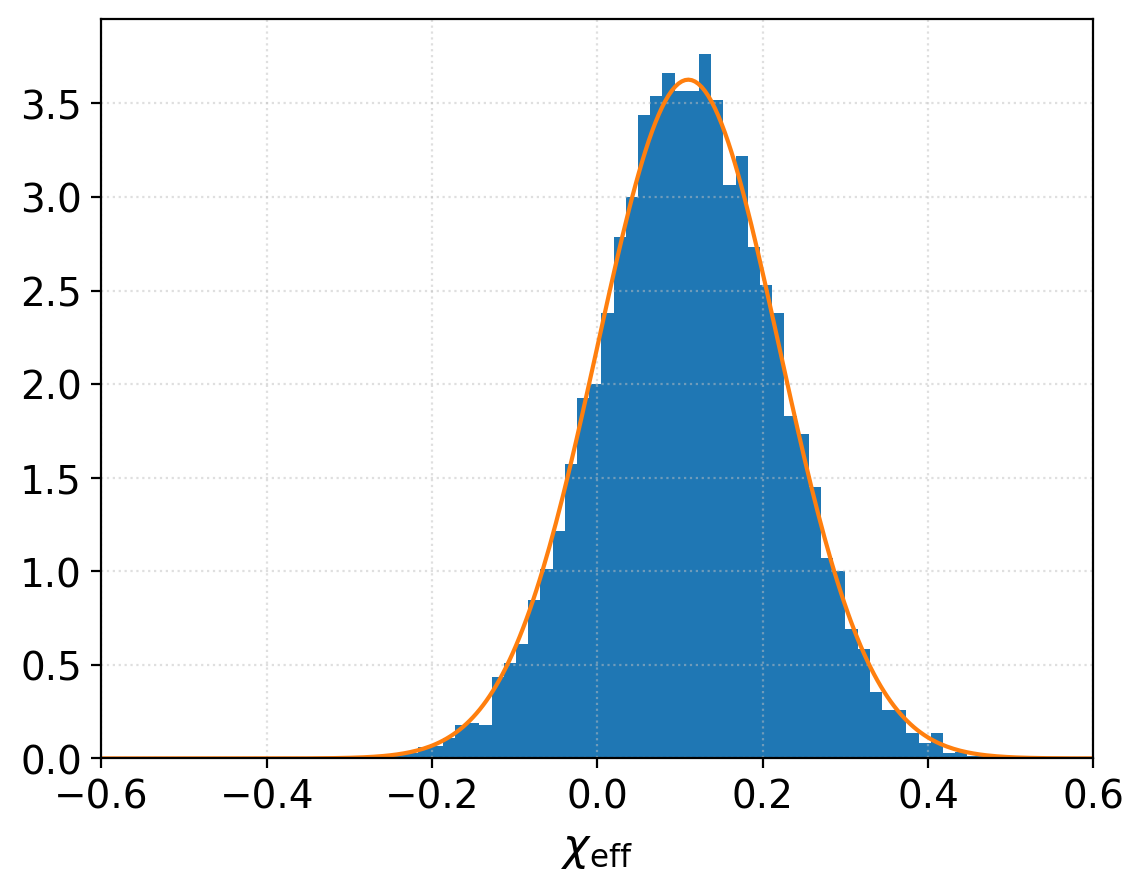

In [9]:
# Analytically fitting for p_chieff
chieff_pop1 = (pop1_detected.m1*pop1_detected.s1z + pop1_detected.m2*pop1_detected.s2z)/(pop1_detected.m1 + pop1_detected.m2)

plt.hist(chieff_pop1, density=True, bins=50)
plt.plot(np.linspace(-1,1,500), calculate_Gaussian_1D(np.linspace(-1,1,500), 0.11, 0.11, -1, 1))
plt.grid(color='silver', ls=':', alpha=0.5)
plt.xlim(-0.6, 0.6)
plt.xlabel(r'$\chi_\mathrm{eff}$', fontsize=16)
plt.show()

## Look at mass and redshift distributions

Show be the same for all three populations.

In [10]:
mMin=6.00
mMax=88.21 
massbins = np.linspace(mMin,mMax,20)
massgrid = np.linspace(mMin,mMax,1000)
qgrid = np.linspace(0,1,1000)

mChirpMin = np.power(mMin*mMin, 3./5)/np.power(mMin+mMin, 1./5)
mChirpMax = np.power(mMax*mMax, 3./5)/np.power(mMax+mMax, 1./5)

In [11]:
sys.path.append('./../../Code/PopulationInference')
from posterior_helper_functions import smoothing_fxn

def p_m1(m1, alpha=-3.51, mMin=6.00, mMax=88.21, lambda_peak=0.033, m0=33.61, sigM=4.72, deltaM=4.88):

    # power law
    p_m1_pl = (1.+alpha)*m1**alpha/(mMax**(1.+alpha) - mMin**(1.+alpha))
    p_m1_pl[m1>mMax] = 0.
    
    # gaussian peak
    p_m1_peak = np.exp(-0.5*(m1-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    p_m1 = lambda_peak*p_m1_peak + (1.-lambda_peak)*p_m1_pl
    
    # smoothing fxn 
    p_m1[m1<mMin+deltaM] = p_m1[m1<mMin+deltaM]*smoothing_fxn(m1[m1<mMin+deltaM]-mMin,deltaM)
    
    p_m1[m1<mMin]=0

    return p_m1

/home/simona.miller/measuring-bbh-component-spin/Code/GeneratePopulations/helper_functions.py:203: RuntimeWarning: divide by zero encountered in divide
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


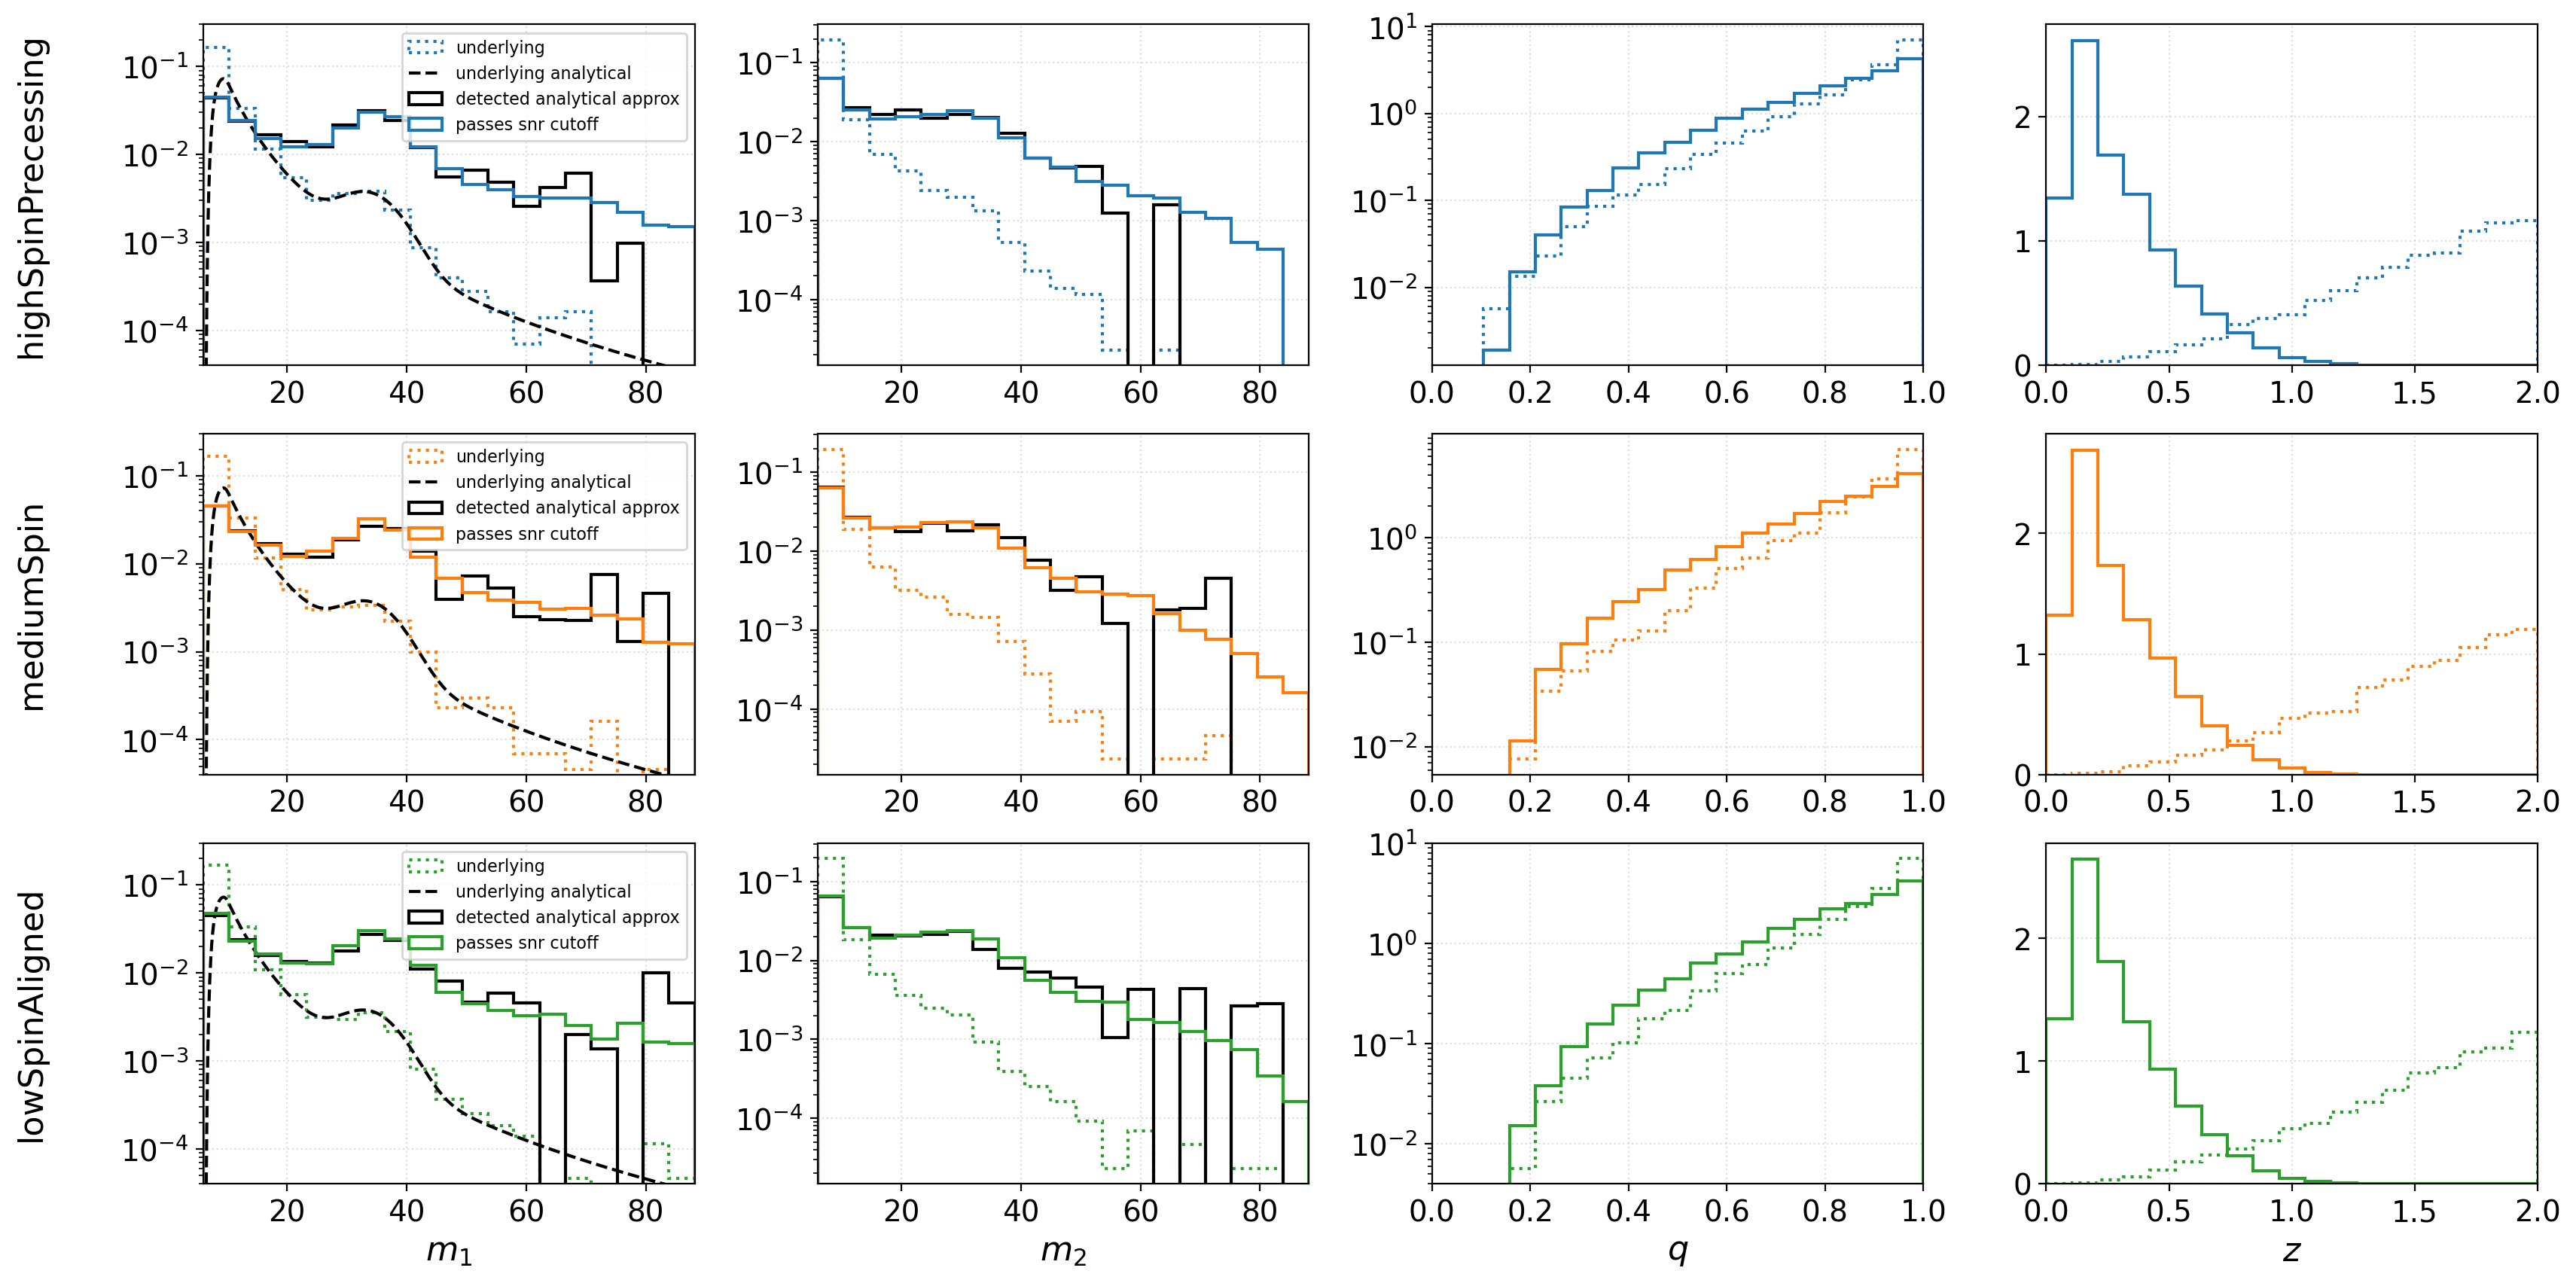

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,10))

for i,pop_underlying in enumerate([pop1_underlying, pop2_underlying, pop3_underlying]):
    # primary mass
    axes[i][0].hist(pop_underlying.m1, **inj_kwargs, color=f'C{i}', bins=massbins)
    axes[i][0].plot(massgrid, p_m1(massgrid), color='k', ls='--', label='underlying analytical')
    axes[i][0].set_yscale('log')
    axes[i][0].set_xlim(mMin,mMax)
    axes[i][0].set_ylim(4e-5, 3e-1)    
    # secondary mass
    axes[i][1].hist(pop_underlying.m2, **inj_kwargs, color=f'C{i}', bins=massbins)
    axes[i][1].set_yscale('log')
    axes[i][1].set_xlim(mMin,mMax)
    # mass ratio 
    axes[i][2].hist(pop_underlying.m2/pop_underlying.m1, **inj_kwargs, color=f'C{i}', bins=np.linspace(0,1,20))
    axes[i][2].set_yscale('log')
    axes[i][2].set_xlim(0,1)
    # redshift
    axes[i][3].hist(pop_underlying.z, **inj_kwargs, color=f'C{i}', bins=np.linspace(0,2,20))
    axes[i][3].set_xlim(0,2)
    
    # Selection effects should go as approximately mchirp^(5/2)
    mchirp_inj = np.power(pop_underlying.m1*pop_underlying.m2, 3./5)/np.power(pop_underlying.m1+pop_underlying.m2, 1./5)
    mass_weights = np.power(mchirp_inj, 5/2)
    mass_weights_normed = mass_weights/np.sum(mass_weights)
    axes[i][0].hist(pop_underlying.m1, color='k', histtype='step', bins=massbins, density=True, lw=1.5, weights=mass_weights_normed, label='detected analytical approx')
    axes[i][1].hist(pop_underlying.m2, color='k', histtype='step', bins=massbins, density=True, lw=1.5, weights=mass_weights_normed)

for i,pop_detected in enumerate([pop1_detected,pop2_detected,pop3_detected]):
    # primary mass
    axes[i][0].hist(pop_detected.m1, **det_kwargs, color=f'C{i}', bins=massbins)
    # secondary mass
    axes[i][1].hist(pop_detected.m2, **det_kwargs, color=f'C{i}', bins=massbins)
    # mass ratio 
    axes[i][2].hist(pop_detected.m2/pop_detected.m1, **det_kwargs, color=f'C{i}', bins=np.linspace(0,1,20))
    # redshift
    axes[i][3].hist(pop_detected.z, **det_kwargs, color=f'C{i}', bins=np.linspace(0,2,20))
    
    axes[i][0].legend(fontsize=8)    
    
axes[2][0].set_xlabel(r'$m_1$', fontsize=16)
axes[2][1].set_xlabel(r'$m_2$', fontsize=16)
axes[2][2].set_xlabel(r'$q$', fontsize=16)
axes[2][3].set_xlabel(r'$z$', fontsize=16)  

axes[0][0].set_ylabel('highSpinPrecessing', fontsize=16, rotation=90, labelpad=35)
axes[1][0].set_ylabel('mediumSpin', fontsize=16, rotation=90, labelpad=35)
axes[2][0].set_ylabel('lowSpinAligned', fontsize=16, rotation=90, labelpad=35)

for ax in axes: 
    for a in ax: 
        a.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

## Look at extrinsic parameters

Should be the same for all three populations

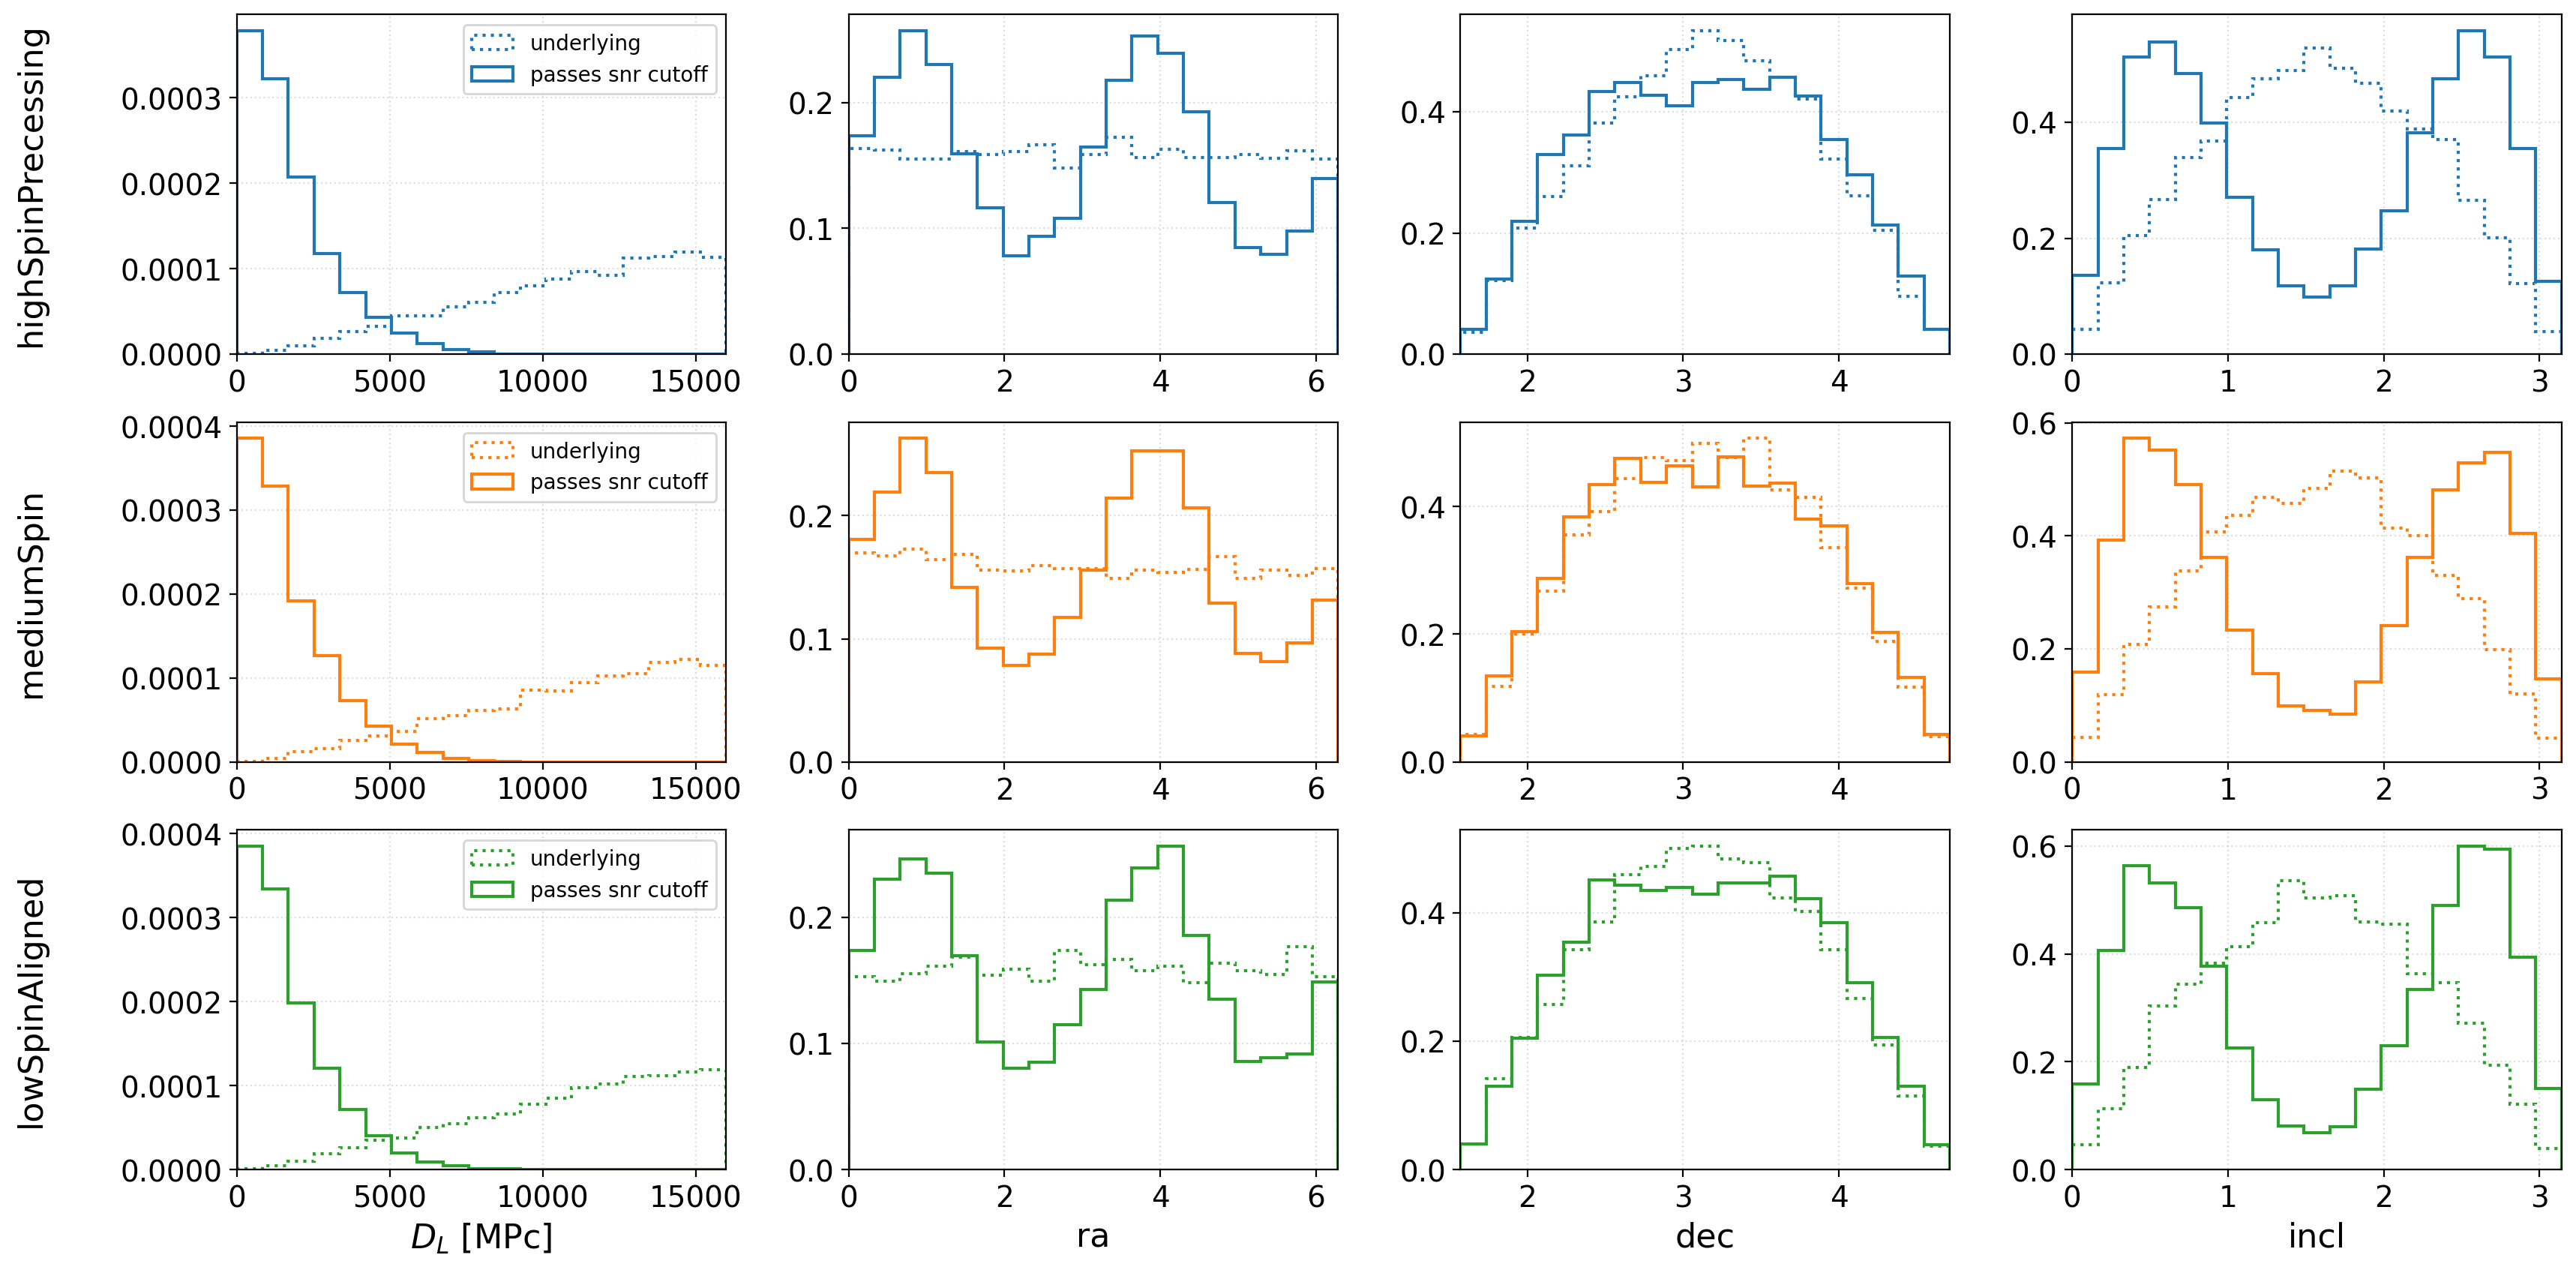

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,10))

for i,pop_underlying in enumerate([pop1_underlying, pop2_underlying, pop3_underlying]):
  
    # luminosity distance
    axes[i][0].hist(pop_underlying.Dl, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 16000, 20))
    axes[i][0].set_xlim(0,16000)
    # right ascension
    axes[i][1].hist(pop_underlying.ra, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, 2*np.pi, 20))
    axes[i][1].set_xlim(0,2*np.pi)
    # declination
    axes[i][2].hist(pop_underlying.dec, **inj_kwargs, color=f'C{i}', bins=np.linspace(np.pi/2, 3/2*np.pi, 20))
    axes[i][2].set_xlim(np.pi/2, 3/2*np.pi)
    # inclination
    axes[i][3].hist(pop_underlying.inc, **inj_kwargs, color=f'C{i}', bins=np.linspace(0, np.pi, 20))
    axes[i][3].set_xlim(0, np.pi)

for i,pop_detected in enumerate([pop1_detected,pop2_detected,pop3_detected]):

    # luminosity distance
    axes[i][0].hist(pop_detected.Dl, **det_kwargs, color=f'C{i}', bins=np.linspace(0, 16000, 20))
    # right ascension
    axes[i][1].hist(pop_detected.ra, **det_kwargs, color=f'C{i}', bins=np.linspace(0, 2*np.pi, 20))
    # declination)
    axes[i][2].hist(pop_detected.dec, **det_kwargs, color=f'C{i}', bins=np.linspace(np.pi/2, 3/2*np.pi, 20))
    # inclination
    axes[i][3].hist(pop_detected.inc, **det_kwargs, color=f'C{i}', bins=np.linspace(0, np.pi, 20))
    
    axes[i][0].legend() 

axes[2][0].set_xlabel(r'$D_L$ [MPc]', fontsize=16)
axes[2][1].set_xlabel(r'ra', fontsize=16)
axes[2][2].set_xlabel(r'dec', fontsize=16)
axes[2][3].set_xlabel(r'incl', fontsize=16)  

axes[0][0].set_ylabel('highSpinPrecessing', fontsize=16, rotation=90, labelpad=35)
axes[1][0].set_ylabel('mediumSpin', fontsize=16, rotation=90, labelpad=35)
axes[2][0].set_ylabel('lowSpinAligned', fontsize=16, rotation=90, labelpad=35)

for ax in axes: 
    for a in ax: 
        a.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

### For `injectionDict`

In [15]:
injectionDictPop = pd.read_json('flat_pop_full_mass_range_for_injection_dict.json')
injectionDictPop_underlying = pd.read_json('underlying_flat_pop_full_mass_range_for_injection_dict.json')

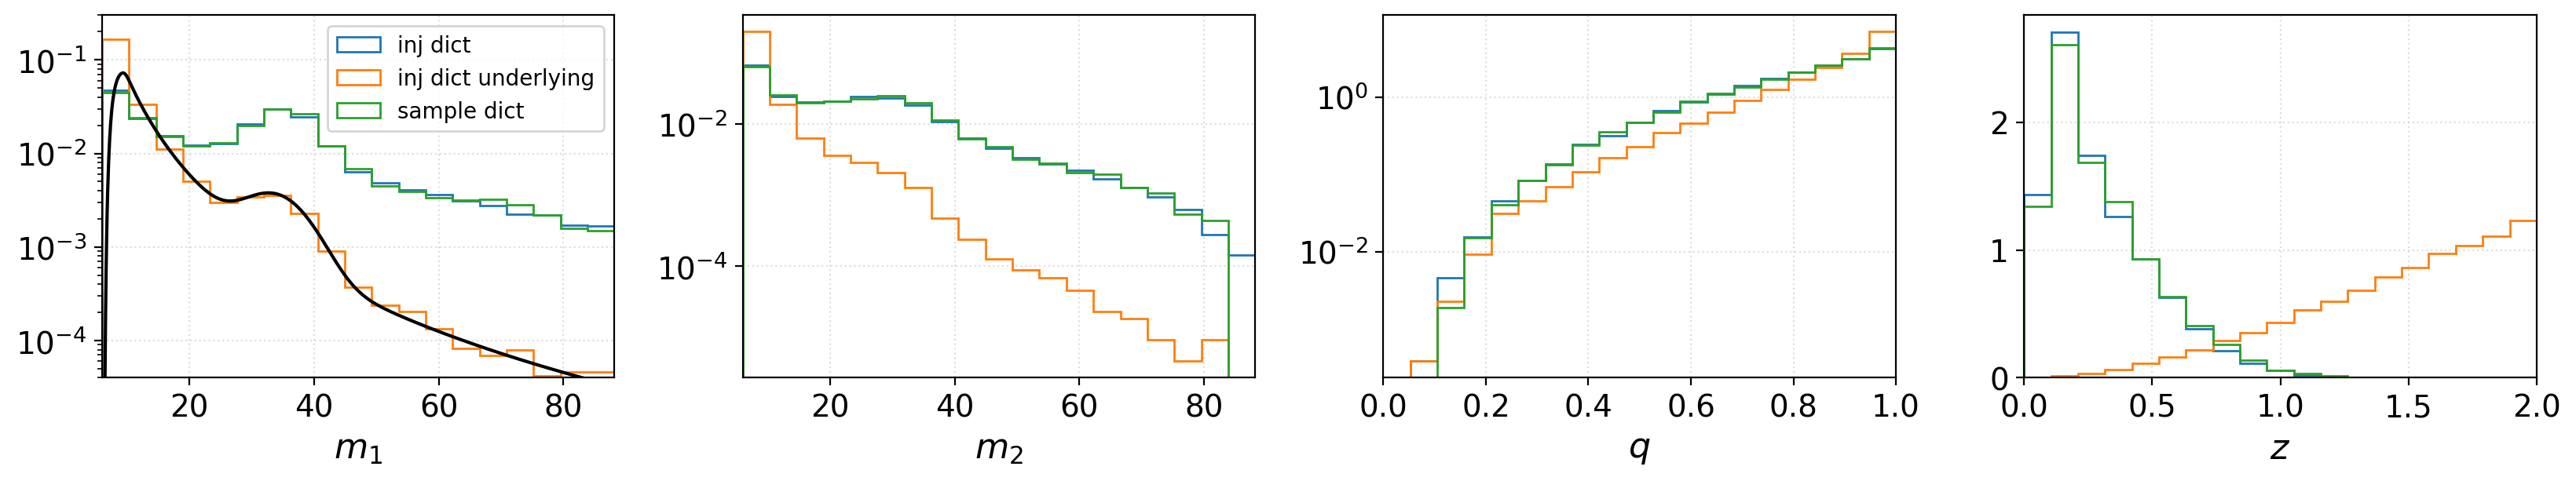

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,3))

# primary mass
axes[0].hist(injectionDictPop.m1, bins=massbins, density=True, histtype='step', label='inj dict')
axes[0].hist(injectionDictPop_underlying.m1, bins=massbins, density=True, histtype='step', label='inj dict underlying')
axes[0].hist(pop1_detected.m1, bins=massbins, density=True, histtype='step', label='sample dict')
axes[0].plot(massgrid, p_m1(massgrid), color='k')
axes[0].set_yscale('log')
axes[0].set_xlim(mMin,mMax)
axes[0].set_ylim(4e-5, 3e-1)

# secondary mass
axes[1].hist(injectionDictPop.m2, bins=massbins, density=True, histtype='step')
axes[1].hist(injectionDictPop_underlying.m2, bins=massbins, density=True, histtype='step')
axes[1].hist(pop1_detected.m2, bins=massbins, density=True, histtype='step')
axes[1].set_yscale('log')
axes[1].set_xlim(mMin,mMax)

# mass ratio 
axes[2].hist(injectionDictPop.m2/injectionDictPop.m1, bins=np.linspace(0,1,20), density=True, histtype='step')
axes[2].hist(injectionDictPop_underlying.m2/injectionDictPop_underlying.m1, bins=np.linspace(0,1,20), density=True, histtype='step')
axes[2].hist(pop1_detected.m2/pop1_detected.m1, bins=np.linspace(0,1,20), density=True, histtype='step')
axes[2].set_yscale('log')
axes[2].set_xlim(0,1)

# redshift
axes[3].hist(injectionDictPop.z, bins=np.linspace(0,2,20), density=True, histtype='step')
axes[3].hist(injectionDictPop_underlying.z, bins=np.linspace(0,2,20), density=True, histtype='step')
axes[3].hist(pop1_detected.z, bins=np.linspace(0,2,20), density=True, histtype='step')
axes[3].set_xlim(0,2)

axes[0].legend()    
    
axes[0].set_xlabel(r'$m_1$', fontsize=16)
axes[1].set_xlabel(r'$m_2$', fontsize=16)
axes[2].set_xlabel(r'$q$', fontsize=16)
axes[3].set_xlabel(r'$z$', fontsize=16)  

for ax in axes: 
    ax.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()

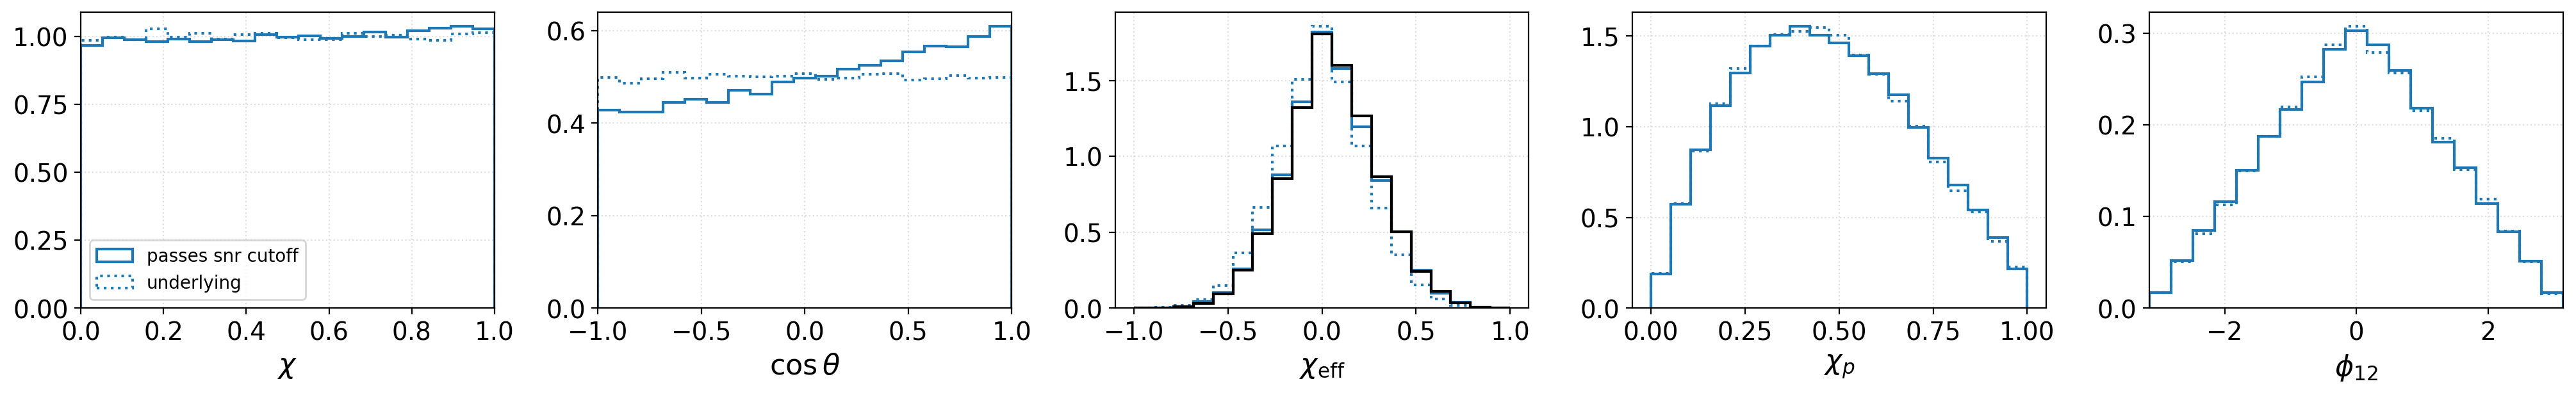

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,3))
    
# spin magnitude
chi1 = np.sqrt(injectionDictPop.s1x**2 + injectionDictPop.s1y**2 + injectionDictPop.s1z**2)
chi2 = np.sqrt(injectionDictPop.s2x**2 + injectionDictPop.s2y**2 + injectionDictPop.s2z**2)
chi = np.concatenate((chi1,chi2))
chi1_inj = np.sqrt(injectionDictPop_underlying.s1x**2 + injectionDictPop_underlying.s1y**2 + injectionDictPop_underlying.s1z**2)
chi2_inj = np.sqrt(injectionDictPop_underlying.s2x**2 + injectionDictPop_underlying.s2y**2 + injectionDictPop_underlying.s2z**2)
chi_inj = np.concatenate((chi1_inj,chi2_inj))

axes[0].hist(chi, **det_kwargs, bins=np.linspace(0, 1, 20), color='C0')
axes[0].hist(chi_inj, **inj_kwargs, bins=np.linspace(0, 1, 20), color='C0')
axes[0].set_xlim(0,1)

# tilt angle
cost1 = injectionDictPop.s1z/chi1
cost2 = injectionDictPop.s2z/chi2
cost = np.concatenate((cost1,cost2))
cost1_inj = injectionDictPop_underlying.s1z/chi1_inj
cost2_inj = injectionDictPop_underlying.s2z/chi2_inj
cost_inj = np.concatenate((cost1_inj,cost2_inj))

axes[1].hist(cost, **det_kwargs, bins=np.linspace(-1,1, 20), color='C0')         
axes[1].hist(np.concatenate((cost1_inj,cost2_inj)), **inj_kwargs, bins=np.linspace(-1,1, 20), color='C0')
axes[1].set_xlim(-1,1)

# chi effective
chieff = (injectionDictPop.m1*injectionDictPop.s1z + injectionDictPop.m2*injectionDictPop.s2z)/(injectionDictPop.m1 + injectionDictPop.m2)
axes[2].hist(chieff, **det_kwargs, bins=np.linspace(-1, 1, 20), color='C0')
chieff_inj = (injectionDictPop_underlying.m1*injectionDictPop_underlying.s1z + injectionDictPop_underlying.m2*injectionDictPop_underlying.s2z)/(injectionDictPop_underlying.m1 + injectionDictPop_underlying.m2)
axes[2].hist(chieff_inj, **inj_kwargs, bins=np.linspace(-1, 1, 20), color='C0')

# chi p
chip = calculate_ChiP(chi1, chi2, np.sin(np.arccos(cost1)), np.sin(np.arccos(cost2)), injectionDictPop.m2/injectionDictPop.m1)
axes[3].hist(chip, **det_kwargs,bins=np.linspace(0, 1, 20), color='C0')
chip_inj = calculate_ChiP(chi1_inj, chi2_inj, np.sin(np.arccos(cost1_inj)), np.sin(np.arccos(cost2_inj)), 
                          injectionDictPop.m2/injectionDictPop.m1)
axes[3].hist(chip_inj, **inj_kwargs,bins=np.linspace(0, 1, 20), color='C0')

# phi 12
phi12 = calculate_phi12(injectionDictPop.s1x,injectionDictPop.s1y,injectionDictPop.s2x,injectionDictPop.s2y)
phi12_inj = calculate_phi12(injectionDictPop_underlying.s1x,injectionDictPop_underlying.s1y,
                            injectionDictPop_underlying.s2x,injectionDictPop_underlying.s2y)
axes[4].hist(phi12, **det_kwargs, bins=np.linspace(-np.pi, np.pi, 20), color='C0')
axes[4].hist(phi12_inj, **inj_kwargs, bins=np.linspace(-np.pi, np.pi, 20), color='C0')
axes[4].set_xlim(-np.pi, np.pi)

# chi effective reweighted
chieff_weights = kde_will_chieff(chieff_inj)
chieff_weights_normed = chieff_weights/np.sum(chieff_weights_normed)
axes[2].hist(chieff_inj, density=True, histtype='step', color='k', bins=np.linspace(-1, 1, 20),
             weights=chieff_weights_normed, zorder=3, lw=1.5)

axes[0].legend(loc='lower left')    

axes[0].set_xlabel(r'$\chi$', fontsize=16)
axes[1].set_xlabel(r'$\cos\theta$', fontsize=16)
axes[2].set_xlabel(r'$\chi_\mathrm{eff}$', fontsize=16)
axes[3].set_xlabel(r'$\chi_p$', fontsize=16)  
axes[4].set_xlabel(r'$\phi_{12}$', fontsize=16)  

for ax in axes: 
    ax.grid(color='silver', ls=':', alpha=0.5)

plt.subplots_adjust(wspace=0.25)
plt.show()